In [19]:

import numpy as np
from qiskit import *
from qiskit.quantum_info import *
from qiskit.circuit.library import *
from qiskit_aer import Aer


## Hamiltonian Simulation

* simulating the $e^{iPt}$, where P are pauli terms
* in this case we are constructing the circuit for $e^{i \sigma_z \otimes \sigma_z t}$

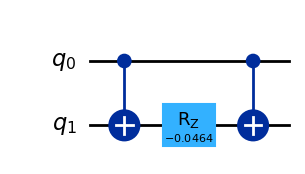

In [ ]:
qc = QuantumCircuit(2)
# qc.x(0)
t =0.0232
qc.cx(0,1)
qc.rz(-2*t, 1)
qc.cx(0,1)
qc.draw('mpl')

In [21]:
state = Statevector(qc)
state.draw('latex')

<IPython.core.display.Latex object>

* now let's see the case for $e^{i \sigma_z \otimes \sigma_x \otimes \sigma_z t}$

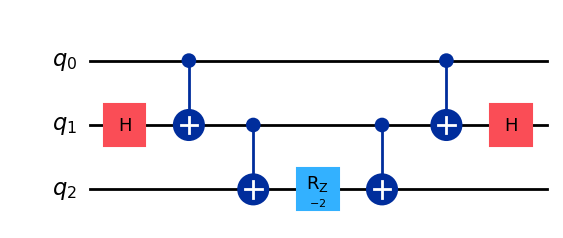

In [22]:
qc = QuantumCircuit(3)
# qc.x(0)

#apply H(Hadamard) for the nth qubit for \sigma_x^(n)
t = 1
qc.h(1)
qc.cx(0,1)
qc.cx(1,2)
qc.rz(-2*t, 2)
qc.cx(1,2)
qc.cx(0,1)
qc.h(1)
qc.draw('mpl')


In [23]:

state = Statevector(qc)
state.draw('latex')

<IPython.core.display.Latex object>

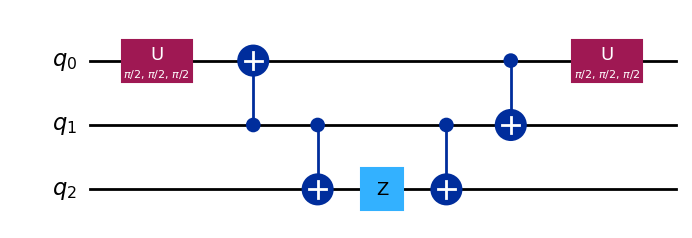

In [24]:
qc = QuantumCircuit(3)

# The unitary for H_y
U = (1 / np.sqrt(2)) * np.array([
    [1, -1j],
    [1j, -1]
])

H_y = UnitaryGate(U, label="Hy")
qc.u(np.pi/2, np.pi/2, np.pi/2, 0)
# qc.append(H_y, [0])
qc.cx(1,0)
qc.cx(1,2)
qc.z(2)
qc.cx(1,2)
qc.cx(0,1)
# qc.append(H_y, [0])
qc.u(np.pi/2, np.pi/2, np.pi/2, 0)

qc.draw('mpl')
# state = Statevector(qc)
# state.draw('')






### Complete code for Hamiltonian solution knowing two things\
- Any hermitian(hamiltonian) can be expressed with the help of pauli terms
- and any pauli terms on the exponential (of the form solved above) we have solution(circuit) 

In [25]:
def exp_pauli_z(qc, qreg, p_ind, cont_qb = None, t=1):

    # this is the case for Ce^iIt
    if len(p_ind) == 0 and cont_qb is not None:
        qc.add_register(cont_qb.register)
        qc.rz(t, cont_qb)
    
    for i in range(len(p_ind) -1):
        qc.cx(qreg[p_ind[i]],
               qreg[p_ind[i+1]])

    if cont_qb is None:
        qc.rz(-2*t, qreg[p_ind[-1]])
    else:
        qc.add_register(cont_qb.register)
        qc.rz(-2*t, cont_qb)
    
    for i in reversed(range(len(p_ind) -1)):
        qc.cx(qreg[p_ind[i]],
              qreg[p_ind[i+1]])
        
    

In [26]:
def exp_pauli(pauli, qreg, cont_qub = None, t=1):

    pauli_circuit = QuantumCircuit(qreg)
    circuit_bracket = QuantumCircuit(qreg)
    pauli_indices = []

    for i in range(len(qreg)):
        if pauli[i] == 'I':
            continue
        elif pauli[i] == 'Z':
            pauli_indices.append(i)
        elif pauli[i] == 'X':
            circuit_bracket.h(qreg[i])
            pauli_indices.append(i)
        elif pauli[i] == 'Y':
            circuit_bracket.u(np.pi/2, np.pi/2, np.pi/2, i)
            pauli_indices.append(i)
    

    pauli_circuit.compose(circuit_bracket, inplace=True)
    exp_pauli_z(pauli_circuit, qreg, pauli_indices, cont_qub, t)
    pauli_circuit.compose(circuit_bracket, inplace=True)

    return pauli_circuit          


In [27]:
def hamiltonian_simulation(hamiltonian, qreg = None, cont_qub = None, t=1, trotter_number = 1):

    # hamitonian in in terms of pauli operators with their corresponding weights will be of the form:
        # hamiltonian = {'XYZ': 5, 'IXZ': 7 ..} 
    if qreg is None:
        qreg = QuantumRegister(len(list(hamiltonian.keys())[0]))
    
    # as of now we always take trotter number as 1
    # if you consider further trotterization then you have to run the hamiltonian simulation the follwing times

    delta_t = t/ trotter_number

    exp_delta_t = QuantumCircuit(qreg)
    exp_hamiltonian = QuantumCircuit(qreg)
    for pauli in hamiltonian:
        weight = hamiltonian[pauli]
        exp_delta_t = exp_delta_t.compose(exp_pauli(pauli, qreg, cont_qub, weight * delta_t) )

    for _ in range(trotter_number):
        exp_hamiltonian = exp_hamiltonian.compose(exp_delta_t)

    return exp_hamiltonian


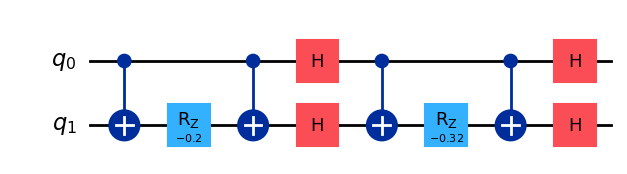

In [50]:
# put the Hamiltonian in the dictionary
hamiltonian = {"ZZ": 0.5, "XX": 0.8}

quantum_register = QuantumRegister(2, 'q')
circuit = hamiltonian_simulation(hamiltonian, 
                                 quantum_register, t=0.2, trotter_number=1)

# draw the circuit 
circuit.draw(output="mpl")
# circuit.measure_all()

In [49]:

sim = Aer.get_backend('aer_simulator')
result = sim.run(circuit).result()
#by default 1024 qubits are measured
counts = result.get_counts()
print(counts['00']/1024)
print(counts['11']/1024)
# print(29/1024)

0.9775390625
0.0224609375
